In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import pandas as pd
from src.embedding.fastembed_ import MiniLmEmbedding
from src.llm.openai_ import OpenLLM
from src.vec_database.hybrid import HybridDatabase
from config import HYBRID_CONN_STRING, OPENAI_KEY
from fastembed import SparseTextEmbedding, LateInteractionTextEmbedding
from src.util import answer_questions


async def gen_answers(filename: str):
    df = pd.read_csv('../data/ideal_answers.csv')

    database = HybridDatabase(
        HYBRID_CONN_STRING,
        MiniLmEmbedding(),
        SparseTextEmbedding("Qdrant/bm25"),
        LateInteractionTextEmbedding("colbert-ir/colbertv2.0")
    )

    collection_name = '1024-txt-indexed-minilm'
    retrieve_limit = 5
    llm = OpenLLM('gpt-4.1-nano', OPENAI_KEY)

    answers = await answer_questions(
        database,
        collection_name,
        retrieve_limit,
        llm,
        df['Question'].tolist(),
        batch_size=10
    )

    df['System Answer'] = answers
    df.to_csv(f'../data/system_answers/{filename}', index=False)

    return df

In [ ]:
# df = gen_answers('hybrid-top5.csv')

In [2]:
df = pd.read_csv('../data/system_answers/verdicts.csv')
df.head()

,Question,Source Docs,Question Type,Source Chunk Type,Answer,System Answer,Meaning,Figures
0,How has Apple's total net sales changed over t...,*AAPL*,Multi-Doc RAG,Table,"Based on the provided documents, Apple's total...","- Q3 2022: $82,959 million\n- Q1 2023: $117,15...",True,True
1,What are the major factors contributing to the...,*AAPL*,Multi-Doc RAG,Text,In the most recent 10-Q for the quarter ended ...,"- Q3 2023: Gross margin $36,413M (44.5%), impa...",True,True
2,Has there been any significant change in Apple...,*AAPL*,Multi-Doc RAG,Table,"Yes, there has been a change in Apple's operat...","- R&D expenses:\n - Q3 2022: $6,797M\n - Q1 ...",True,True
3,How has Apple's revenue from iPhone sales fluc...,*AAPL*,Multi-Doc RAG,Table,The revenue from iPhone sales for Apple has fl...,- Q3 2022: $40.665 billion\n- Q1 2023: $65.775...,True,True
4,Can any trends be identified in Apple's Servic...,*AAPL*,Multi-Doc RAG,Table,"Based on the provided documents, there is a tr...","- Q3 2022: $19,604 million\n- Q1 2023: $20,766...",True,False


In [26]:
df['Company'] = df['Source Docs'].apply(
    func=lambda x: x[1:-1].split()[-1]
)

print(df['Company'].unique())

['AAPL' 'MSFT' 'NVDA' 'INTC' 'AMZN']


In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", rc={
    "figure.facecolor": "#f6efe7",
    "axes.facecolor": "#fbf6ef",
    "axes.edgecolor": "#b79a84",
    "grid.color": "#e7dccf",
    "text.color": "#3d352f",
    "axes.labelcolor": "#3d352f",
    "xtick.color": "#4a403a",
    "ytick.color": "#4a403a",
})

sns.set_palette(["#8D6A5A", "#C7A48E", "#A47551", "#D8B094", "#9C7B6E"])

In [66]:
def gen_grouped_bar_plot(column: str):
    agg_df = (
        df.groupby(column, as_index=False)[["Meaning", "Figures"]]
        .mean()
    )

    long_df = agg_df.melt(
        id_vars=column,
        value_vars=["Meaning", "Figures"],
        var_name="Metric",
        value_name="Value",
    )
    plt.figure(figsize=(20, 10))

    ax = sns.barplot(
        data=long_df,
        x=column,
        y="Value",
        hue="Metric",
        hue_order=["Meaning", "Figures"],
        errorbar=None,
    )

    ax.set_title(f"Meaning vs Figures by {column}")
    ax.set_xlabel(column)
    ax.set_ylabel("Value")
    plt.legend(title="Metric")

    plt.show()

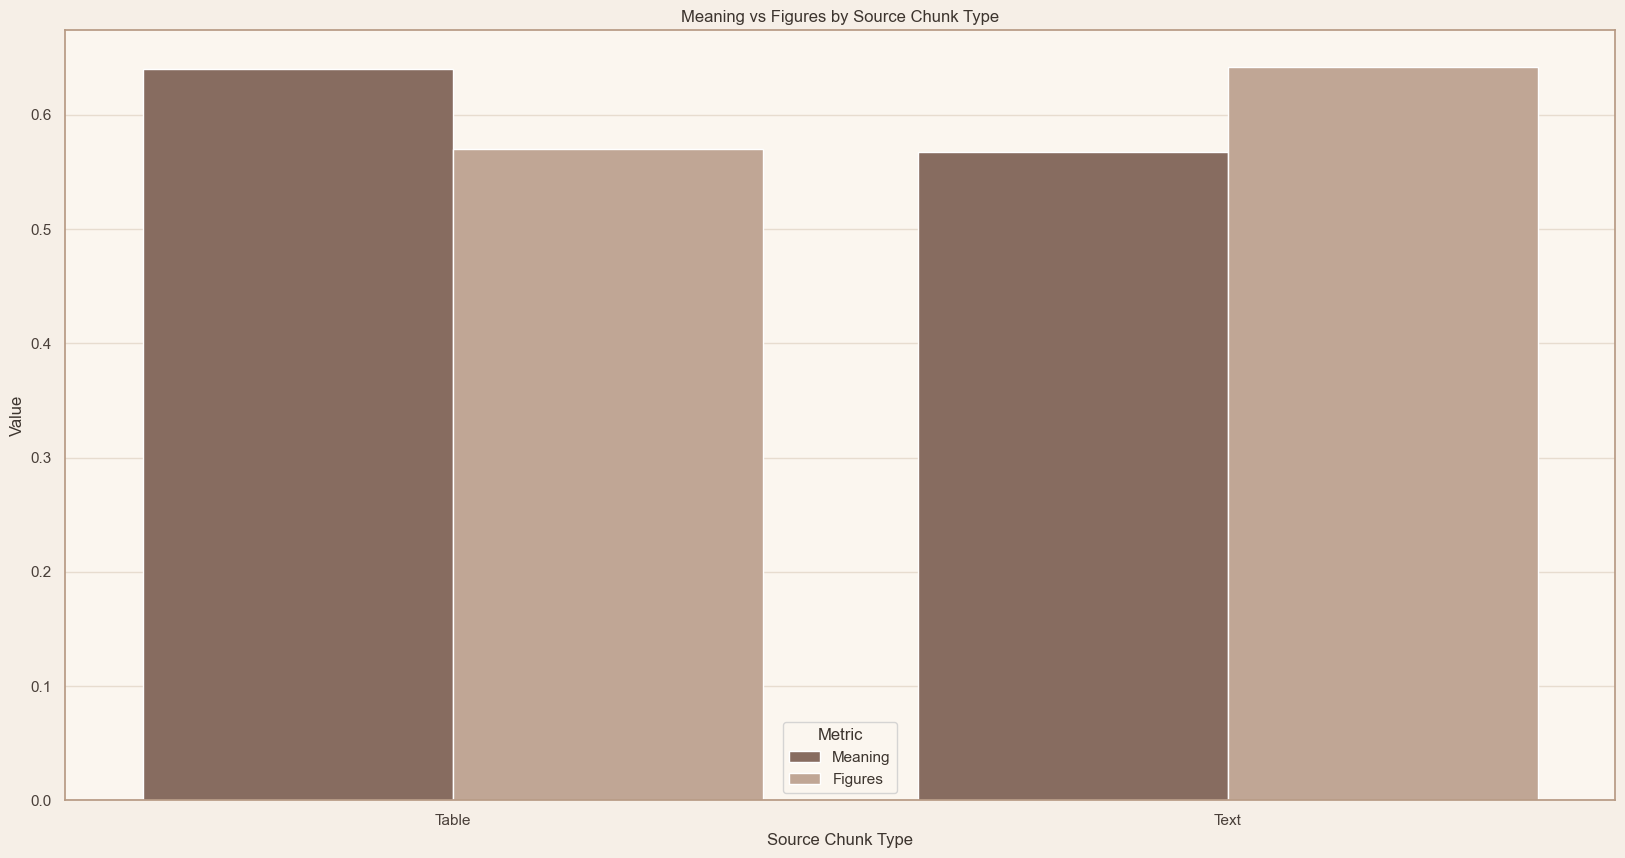

In [67]:
gen_grouped_bar_plot('Source Chunk Type')

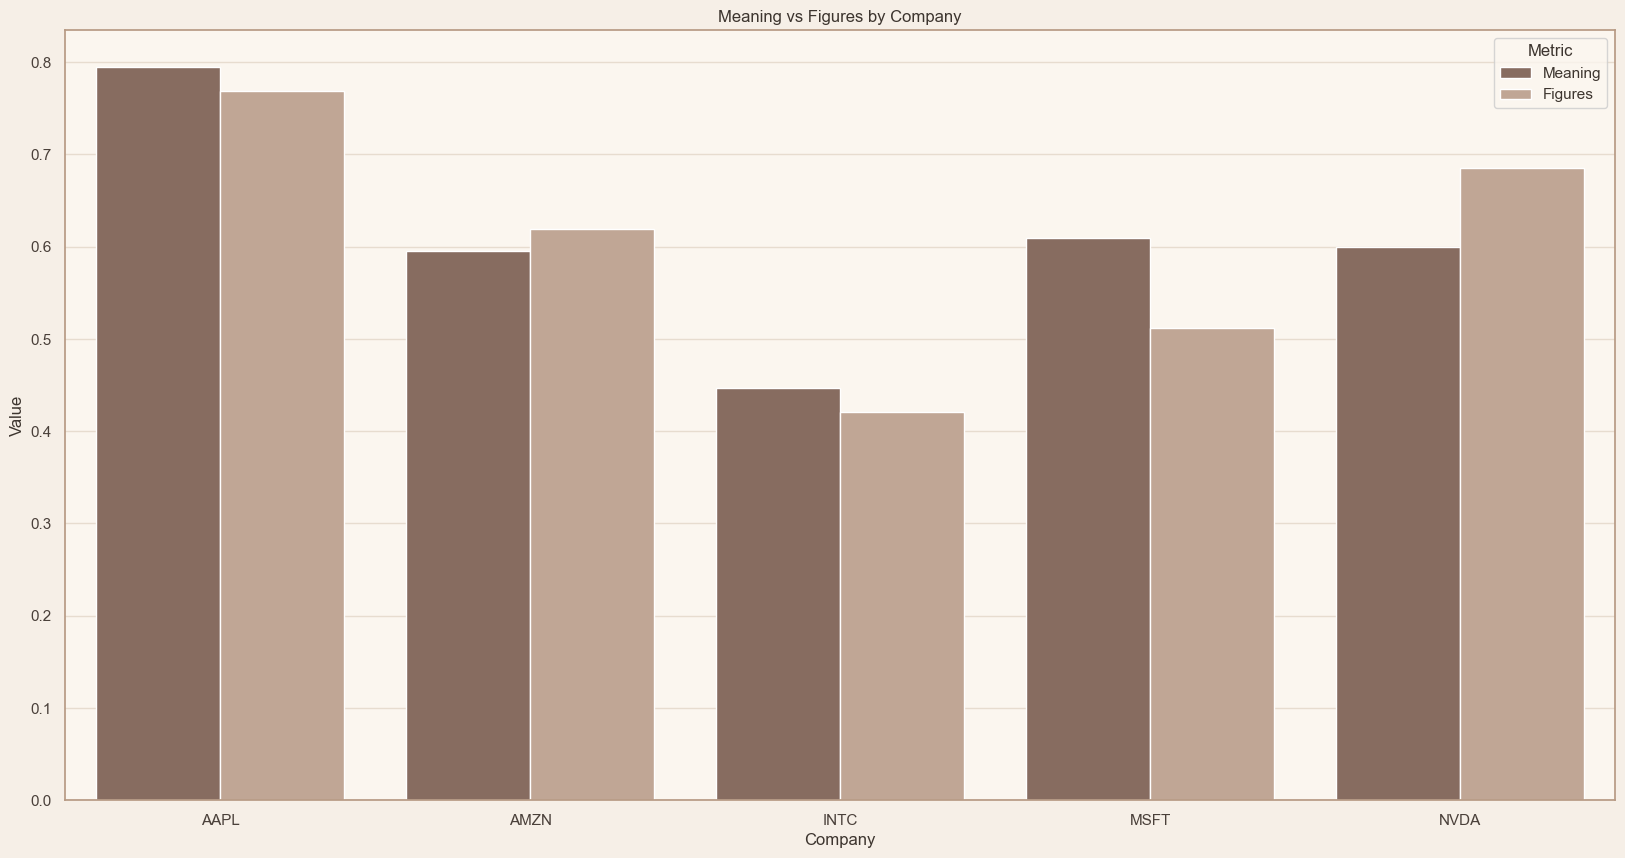

In [68]:
gen_grouped_bar_plot('Company')

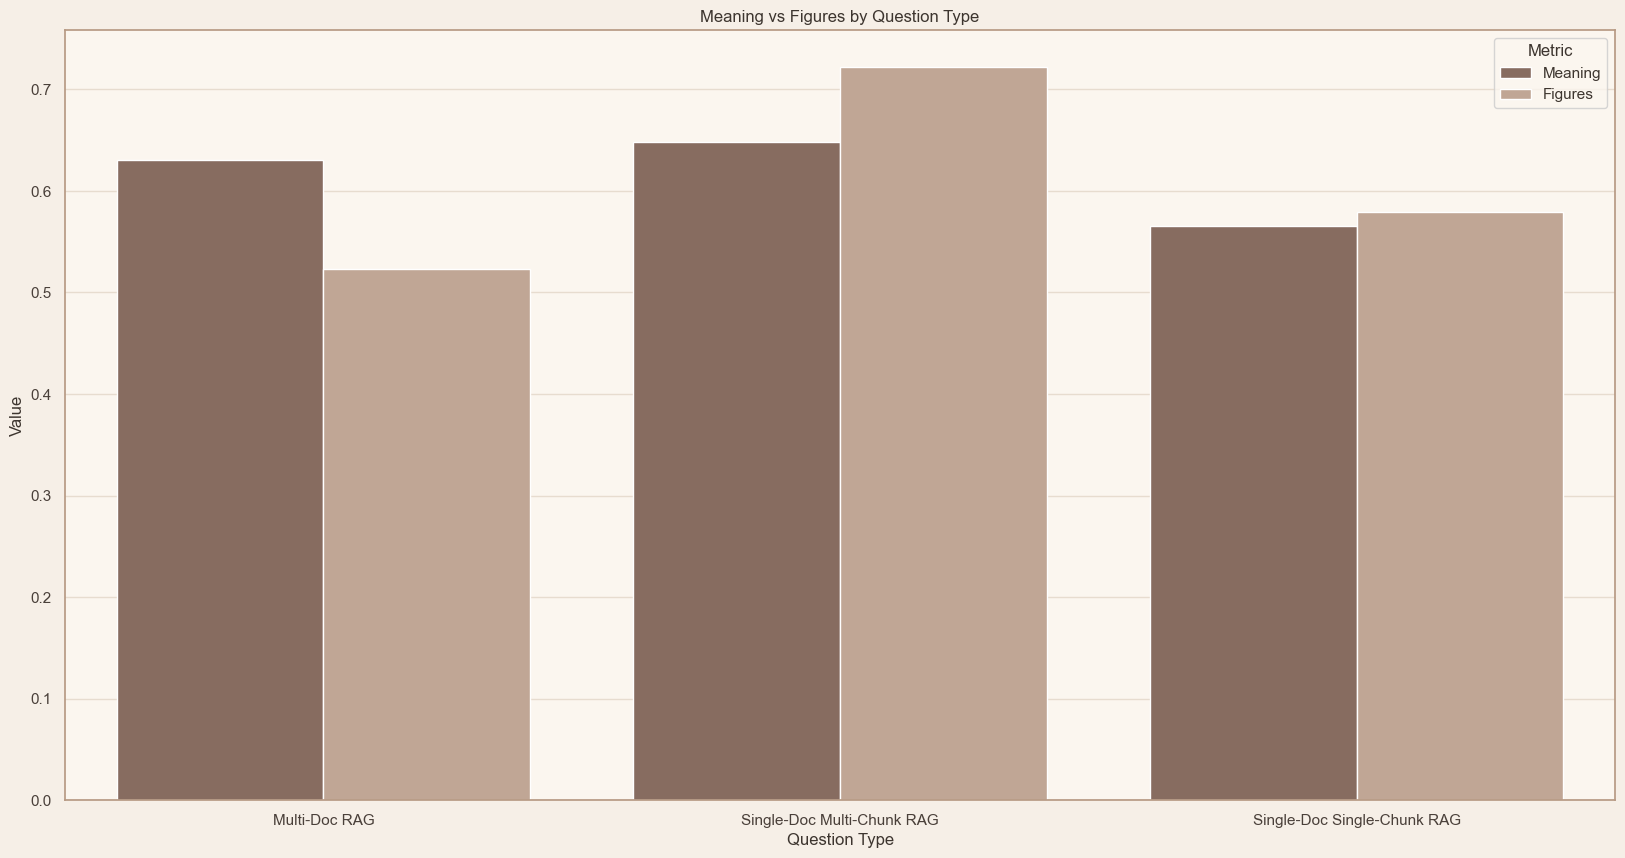

In [69]:
gen_grouped_bar_plot('Question Type')